In [512]:
library(readxl)
library(data.table)
library(ggplot2)
library(ggprism)
library(ggforce)
library(ggetho)
library(ggsignif)
theme_set(theme_prism(base_size=20))
options(repr.plot.width=15, repr.plot.height=15)

In [651]:
sheets <- c("20min STM", "1hr STM", "2hr STM", "3hr STM")
zts <- paste0("ZT", as.character(round(seq(4, 30, .5), 1)))

dts <- lapply(sheets, function(sheet) {
    x <- cbind(
            as.data.table(suppressMessages(readxl::read_xlsx("IDOC_METHODS_PAPER_METADATA.xlsx", sheet = sheet, skip = 2)))[, .(Fly_group_experiment_treatment, fly_name_reference, PRE, POST)],
            experiment = sheet
        )
    for (zt in zts) {
        x[[zt]] <- NA_real_
    } 
    x
    

})

In [652]:
idoc_dir <- "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001/"
idoc_folders <- list.files(idoc_dir, full.names = T)
idoc_folders <- idoc_folders[grep(pattern = "2021", x = idoc_folders)]

ltm_chx <-lapply(
    idoc_folders,
    function(idoc_folder) {
        print(idoc_folder)
        exp_date <- substr(basename(idoc_folder), 1, 10)
        subexperiments <- sort(list.files(idoc_folder, full.names = T))
        if ((substr(basename(subexperiments[7]), 1, 10) != exp_date) | (substr(basename(subexperiments[8]), 1, 10) == exp_date)) {
            stop(paste0(idoc_folder, " is corruped"))
        }

        paths <- list.files(subexperiments[1], full.names = T)
        csv_file <- paths[grep(pattern = "_PI.csv", x = paths)]
        data1 <- data.table::fread(csv_file)
        data1 <- cbind(exp_folder=basename(idoc_folder), data1)
        colnames(data1)[colnames(data1) == "preference_index"] <- "PRE"
        data1[, apetitive:=NULL]
        data1[, aversive:=NULL]
        
        
        
        paths <- list.files(subexperiments[8], full.names = T)
        csv_file <- paths[grep(pattern = "_PI.csv", x = paths)]
        data2 <- data.table::fread(csv_file)
        data2 <- cbind(exp_folder=basename(idoc_folder), data2)
        colnames(data2)[colnames(data2) == "preference_index"] <- "POST"
        data2[, apetitive:=NULL]
        data2[, aversive:=NULL]
        
        data <- merge(data1, data2, by=c("exp_folder", "region_id"))
        
        data[, Fly_group_experiment_treatment := "ISO31'_Learning(20min)_OCT_CSplus_EShock_US_Paired_1X -Learning_ETHOSCOPE-NO_CHX"]
        data[, fly_name_reference := paste0(basename(idoc_folder), "_ROI_", region_id)]
        data[, region_id := NULL]
        data[, exp_folder := NULL]
        data[, experiment := "LTM_CHX"]
        for (zt in zts) {
            data[[zt]] <- NA_real_
        } 
        data
        
})
ltm_chx <- do.call(rbind, ltm_chx)
ltm_chx <- ltm_chx[, c("Fly_group_experiment_treatment", "fly_name_reference", "PRE", "POST", "experiment", zts), with=F]

[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-11-27 (CH1)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-11-28 (CH)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-11-30 (CH)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-12-02 (CH)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-12-17 (CH)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-12-17 (CH1)"
[1] "/Users/FlySleepLab Dropbox/Antonio/FSLLab/Projects/IDOC/IDOC_001//2021-12-22 (CH)"


In [653]:
names(dts) <- sheets

In [655]:
ltm <- as.data.table(suppressMessages(readxl::read_xlsx("IDOC_METHODS_PAPER_METADATA.xlsx", sheet = "LTM experiments", skip = 2)))
ltm$experiment <- "LTM"

In [656]:
ltm <- ltm[SD_quality %in% c("No_sleep_depriver", "good") & SD_quality_second_eye %in% c("No_sleep_depriver", "good"),]
nrow(ltm)

[1] 192

In [657]:
ltm <- ltm[, c("Fly_group_experiment_treatment", "fly_name_reference", "PRE", "POST", "experiment", zts), with=F]

In [658]:
ltm <- rbind(ltm, ltm_chx)

In [659]:
dts$LTM <- ltm

In [660]:
data <- do.call(rbind, dts)

In [661]:
# data[, table(Fly_group_experiment_treatment)]

In [662]:
data_clean <- data[!is.na(PRE) & !is.na(POST) & PRE != "NA" & POST != "NA" & PRE != "#VALUE!" & POST != "#VALUE!",]

In [663]:
data_clean$PRE <- as.numeric(data_clean$PRE)
data_clean$POST <- as.numeric(data_clean$POST)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [664]:
data_clean[, table(abs(PRE) < 0.2)]


FALSE  TRUE 
   49   273 

In [665]:
data_clean <- data_clean[abs(PRE) < 0.2,]

In [666]:
data_clean$id <- 1:nrow(data_clean)

In [667]:
sum(duplicated(data_clean$fly_name_reference))

[1] 0

In [681]:
data_clean_long <- melt(data = data_clean, measure.vars = c("PRE", "POST"), value.name = "PI", variable.name = "test")

In [682]:
data_clean_long$test <- factor(as.character(data_clean_long$test), c("PRE", "POST"))

In [683]:
data_clean_long$experiment <- factor(data_clean_long$experiment, levels=c(sheets, "LTM", "LTM_CHX"))

In [684]:
table(data_clean_long$experiment)


20min STM   1hr STM   2hr STM   3hr STM       LTM   LTM_CHX 
       92        56        24       110       136       128 

In [685]:
learning <- sapply(1:nrow(data_clean_long), function(x) {"NONE"})
learning[grep(pattern = "1X", x = data_clean_long$Fly_group_experiment_treatment)] <- "1X"
learning[grep(pattern = "6X_Spaced", x = data_clean_long$Fly_group_experiment_treatment)] <- "6X_Spaced"
data_clean_long$learning <- learning

In [686]:
interval <- sapply(1:nrow(data_clean_long), function(x) {"NONE"})
interval[grep(pattern = "ZT05-ZT24", x = data_clean_long$Fly_group_experiment_treatment)] <- "ZT05-ZT24"
interval[grep(pattern = "ZT05-ZT11", x = data_clean_long$Fly_group_experiment_treatment)] <- "ZT05-ZT11"
interval[grep(pattern = "ZT12-ZT18", x = data_clean_long$Fly_group_experiment_treatment)] <- "ZT12-ZT18"

data_clean_long$interval <- factor(interval, levels=c("ZT05-ZT11", "ZT12-ZT18", "ZT05-ZT24", "NONE"))

In [687]:
panel1A_data <- data_clean_long[interval=="NONE" & experiment %in% c("20min STM", "unpaired", "naive"),]

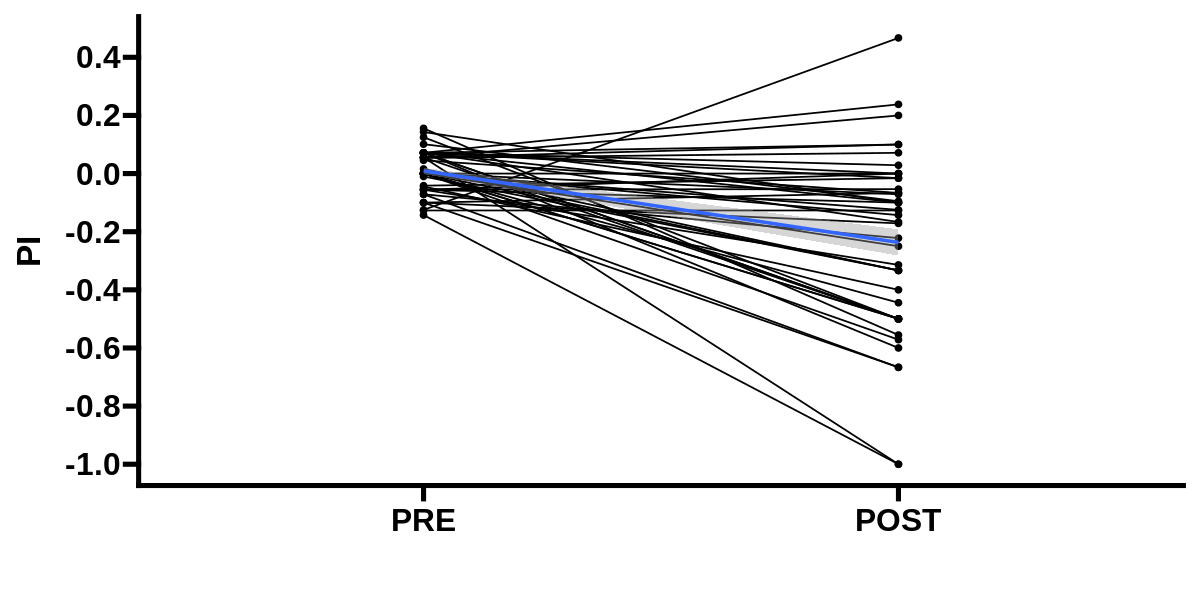

In [688]:
options(repr.plot.height=5)
panel1A <- ggplot(data=panel1A_data, aes(x=test, y = PI, group=experiment)) +
    geom_point() +
    geom_line(aes(group=id)) + geom_pop_etho() +
    scale_y_continuous(breaks=seq(-1, 0.5, 0.2)) + labs(x="") +
    facet_grid(. ~ experiment) +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank()
    )
panel1A

ggsave(plot = panel1A, filename = "figures/figure1A.svg", width=7.5, height=5)

In [695]:
panel2A_data <- data_clean_long[interval=="NONE" & experiment %in% sheets,]
panel2B_data <- dcast(panel2A_data[, .(experiment, id, test, PI)], id + experiment ~ test, value.var="PI")
panel2B_data <- panel2B_data[, .(id, experiment, diff=POST-PRE, Pre=PRE, Post=POST)]

In [696]:
panel2_data <- data.table::copy(panel2A_data)
panel2_data[, group := paste0(experiment, "_", test)]
panel2_data$group <- factor(panel2_data$group, levels=unique(paste0(panel2_data$experiment, "_", panel2_data$test)))

In [697]:
p_values <- sapply(levels(panel2_data$experiment), function(exp){
    x <- panel2_data[experiment==exp & test == "PRE", PI]
    y <- panel2_data[experiment==exp & test == "POST", PI]
    if (length(x) == 0) {return(NA)}
    t.test(
        x = x,
        y = y,
        alternative="two.sided"
    )$p.value
})
p_values

20min STM      1hr STM      2hr STM      3hr STM          LTM      LTM_CHX 
2.503850e-06 1.016987e-06 1.258184e-01 8.925570e-04           NA           NA

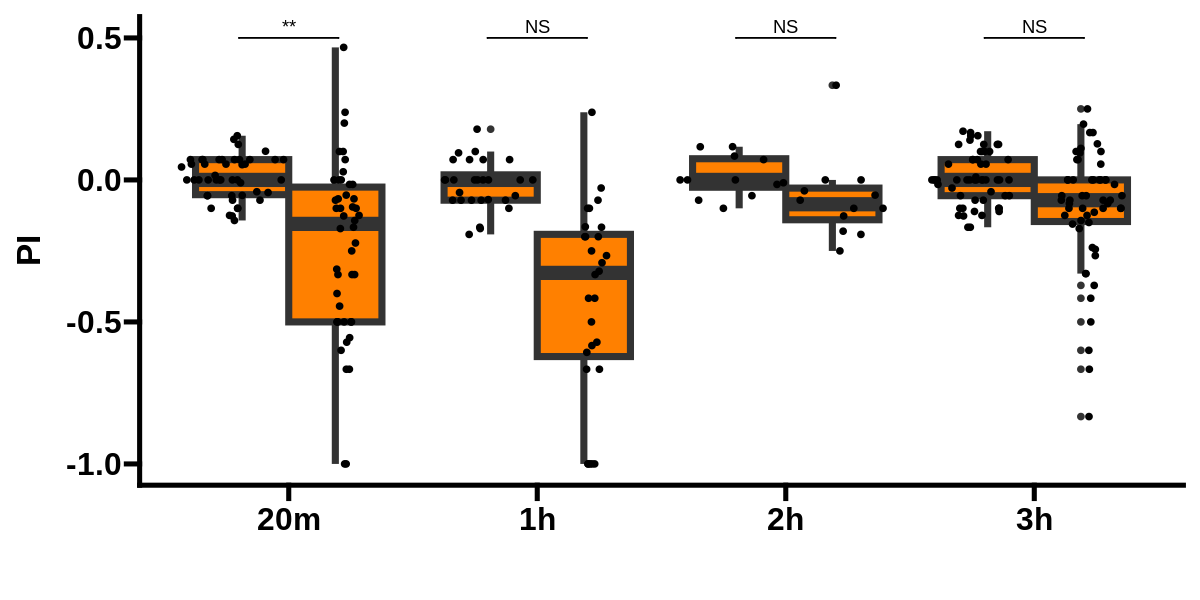

In [698]:
options(repr.plot.height=5)
panel2 <- ggplot(data=panel2_data, aes(x=experiment, y=PI, fill=test)) +
    geom_boxplot(size=2, position="dodge")  +
    geom_sina() +
    scale_x_discrete(labels = c("20m", "1h", "2h", "3h")) +
    labs(y="PI", x="") +
    geom_signif(
        y_position = c(.5, .5, .5, .5), xmin = seq(from=0.8, by=1, length.out = 4), xmax = seq(1.2, by=1, length.out = 4),
        annotation = c("**", "NS", "NS", "NS"), tip_length = 0
    ) + scale_fill_manual(values = c("#ff8000", "#ff8000")) + guides(fill="none")

panel2
ggsave(plot=panel2, filename = "figures/panel2.svg", width=10, height=5)


In [555]:
panel2$scales$x

NULL

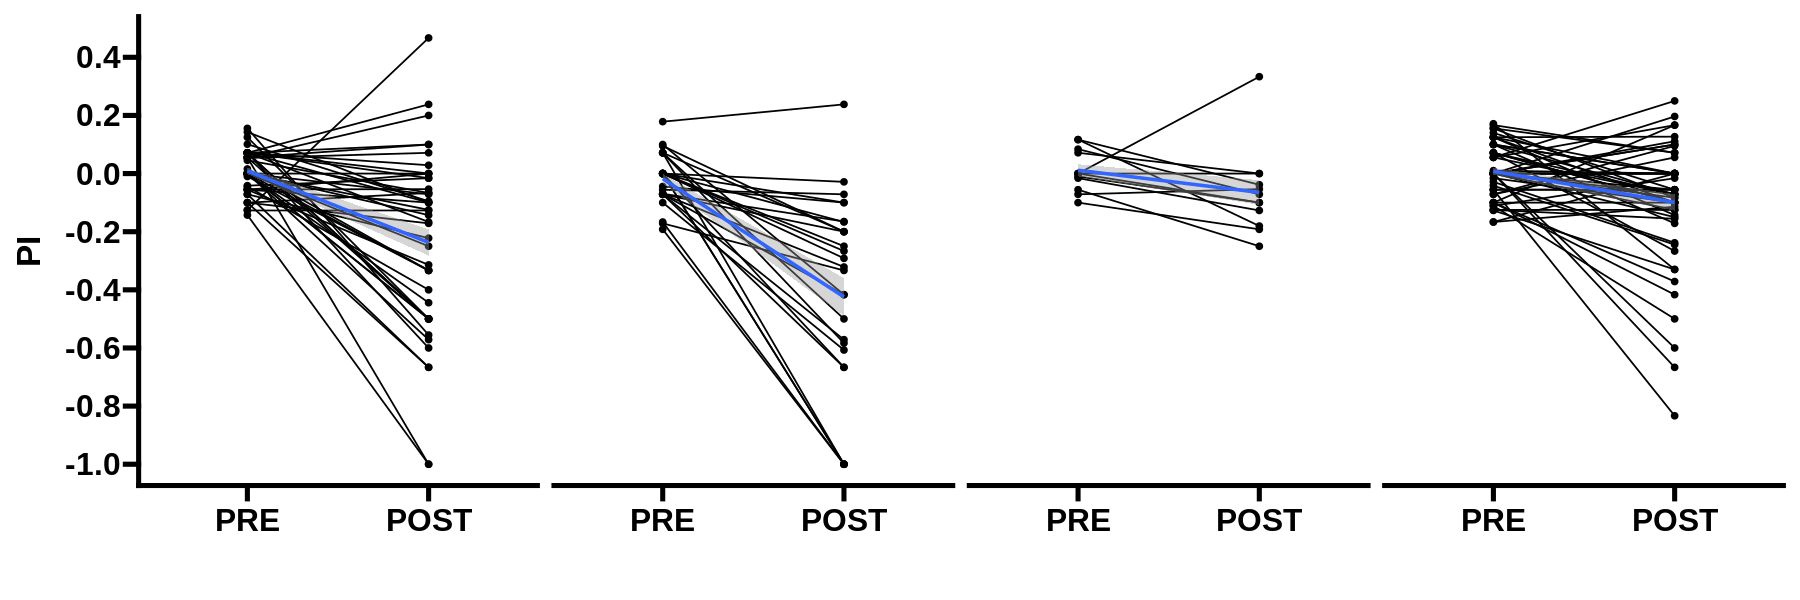

In [556]:
options(repr.plot.height=5)
panel2A <- ggplot(data=panel2A_data, aes(x=test, y = PI, group=experiment)) +
    geom_point() +
    geom_line(aes(group=id)) + geom_pop_etho() +
    scale_y_continuous(breaks=seq(-1, 0.5, 0.2)) + labs(x="") +
    facet_grid(. ~ experiment) +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank()
    )
panel2A

In [559]:
head(panel2B_data)


id,experiment,diff,Pre,Post
<int>,<fct>,<dbl>,<dbl>,<dbl>
1,20min STM,-0.62500000,0.12500000,-0.5000000
2,20min STM,-0.07142857,0.07142857,0.0000000
3,20min STM,-0.17142857,0.07142857,-0.1000000
4,20min STM,-0.50000000,0.00000000,-0.5000000
5,20min STM,-0.07142857,-0.10000000,-0.1714286
6,20min STM,-0.57142857,0.07142857,-0.5000000


In [560]:
panel2B <- ggplot(data=panel2B_data, aes(x=experiment, y=Post)) + geom_boxplot(fill="#ff8000", width=.1, size=2)  + geom_sina() + scale_x_discrete(labels = c("20m", "1h", "2h", "3h")) + labs(y="PI", x="")

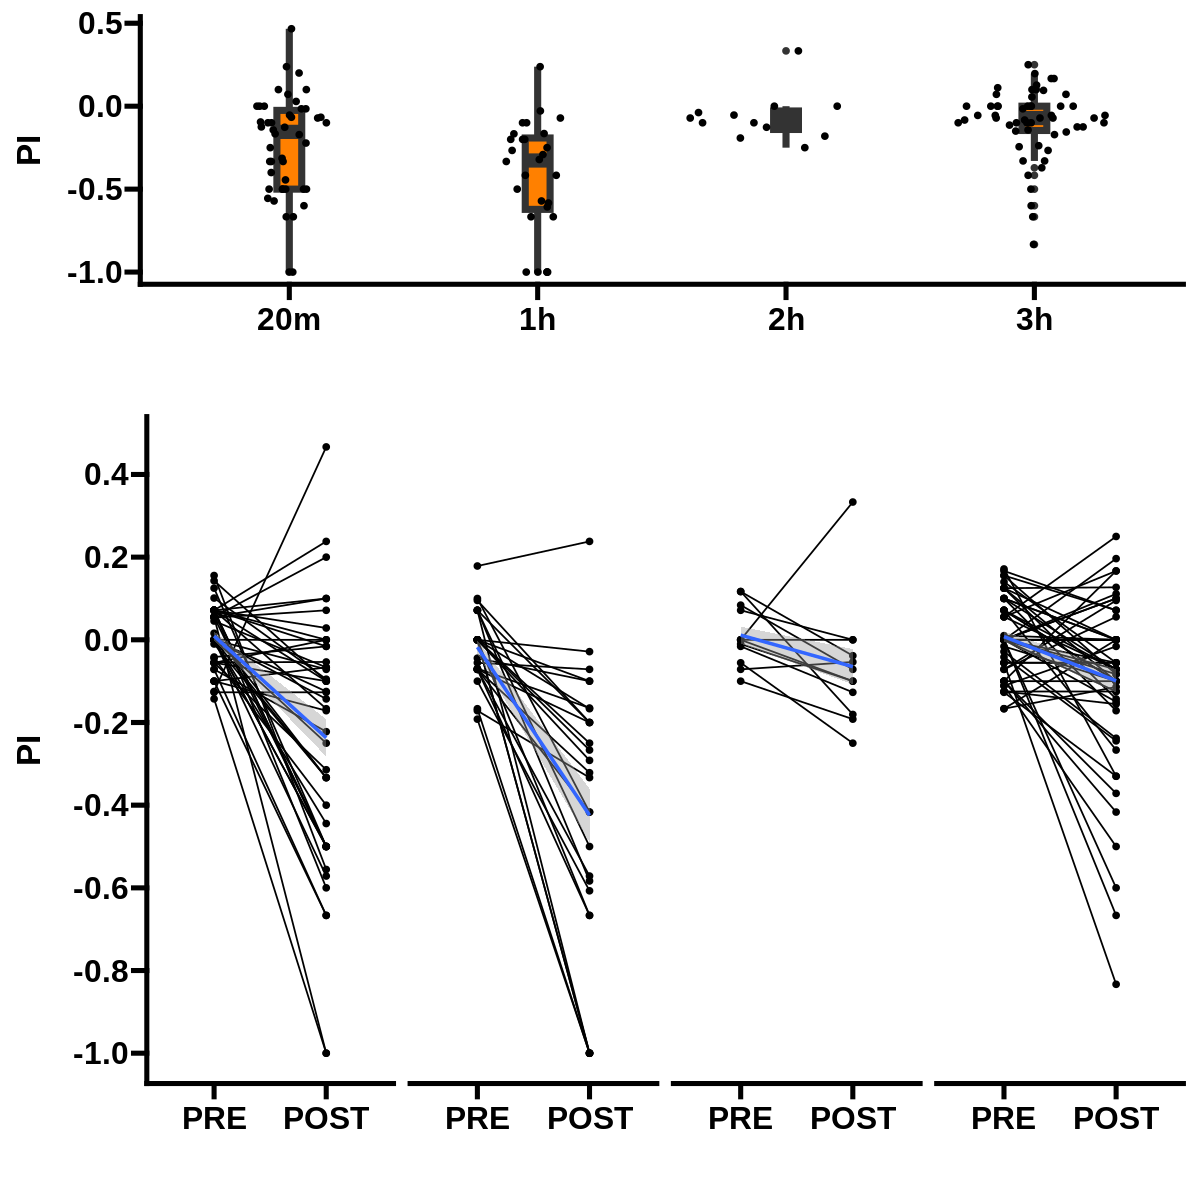

In [561]:
options(repr.plot.width=10)
options(repr.plot.height=10)
cowplot::plot_grid(panel2B, panel2A, nrow=2, rel_heights=c(1.5, 3))

In [564]:
panel3A_data <- data_clean_long[experiment == "LTM"]
panel3A_data[, group := paste0(interval, "_", test)]
panel3A_data$group <- factor(panel3A_data$group, levels=unique(paste0(panel3A_data$interval, "_", panel3A_data$test)))


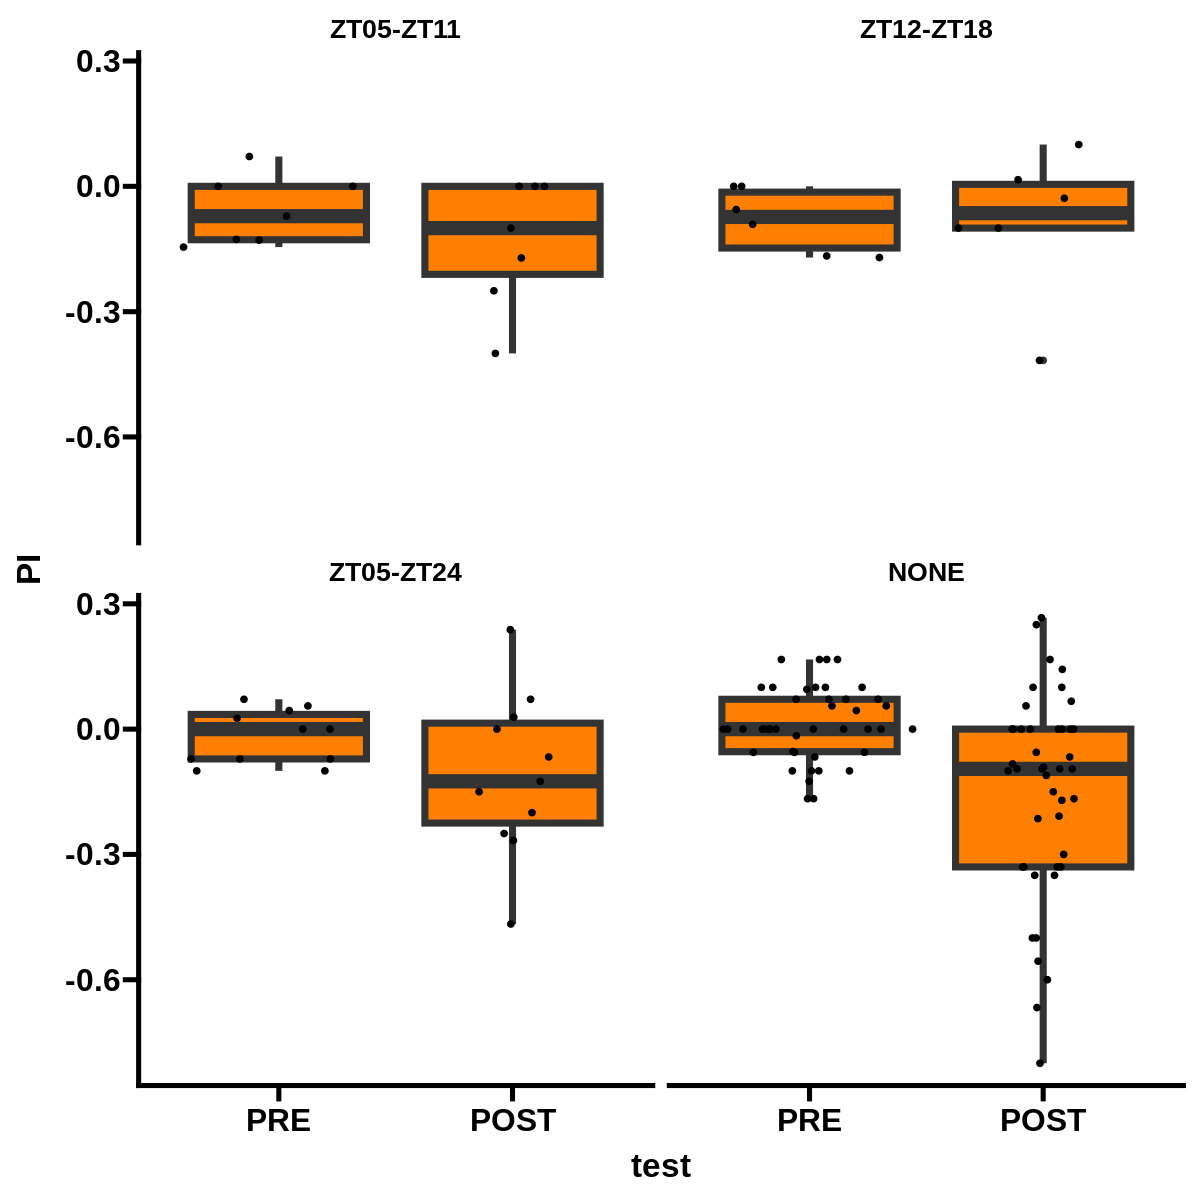

In [565]:
ggplot(data=panel3A_data, aes(x=test, y = PI, group=group)) +
    geom_boxplot(fill="#ff8000", size=2)  +
    geom_sina() +
    facet_wrap("interval")

In [581]:
panel3_data <- data_clean_long[experiment=="LTM", ]
zt_light_phase <- paste0("ZT", seq(4, 10.5, 0.5))
zt_dark_phase <- paste0("ZT", seq(12, 23.5, 0.5))
panel3_data$asleep_total <- apply(panel3_data, MARGIN = 1, function(x) sum(as.numeric(x[zt_light_phase]), na.rm=TRUE)) * 30

Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”
Warning message in FUN(newX[, i], ...):
“NAs introduced by coercion”


In [582]:
panel3_data<-panel3_data[order(interval, test),]

In [583]:
options(repr.plot.height=5)
panel3b <- ggplot(data=panel3_data, aes(x=interval, y=PI, fill=test)) +
    geom_boxplot(size=2, position="dodge")  +
    geom_sina() +
    labs(y="PI", x="") +
    # geom_signif(
    #     y_position = c(.5, .5, .5, .5), xmin = seq(from=0.8, by=1, length.out = 4), xmax = seq(1.2, by=1, length.out = 4),
    #     annotation = c("**", "NS", "NS", "NS"), tip_length = 0
    # ) + 
    scale_fill_manual(values = c("#ff8000", "#ff8000")) + guides(fill="none")
ggsave(filename = "figures/panel3B.svg", plot = panel3b, width=15, height=5)

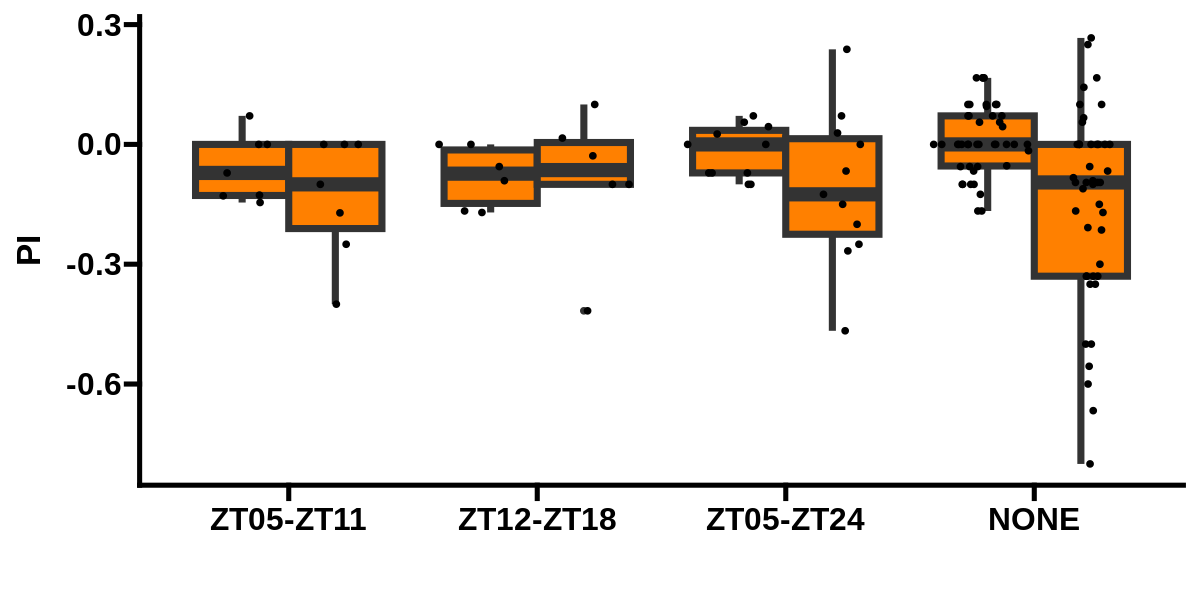

In [587]:
panel3b

In [589]:
panel3_data[test=="PRE", .N, by=interval]

interval,N
<fct>,<int>
ZT05-ZT11,7
ZT12-ZT18,6
ZT05-ZT24,11
NONE,44


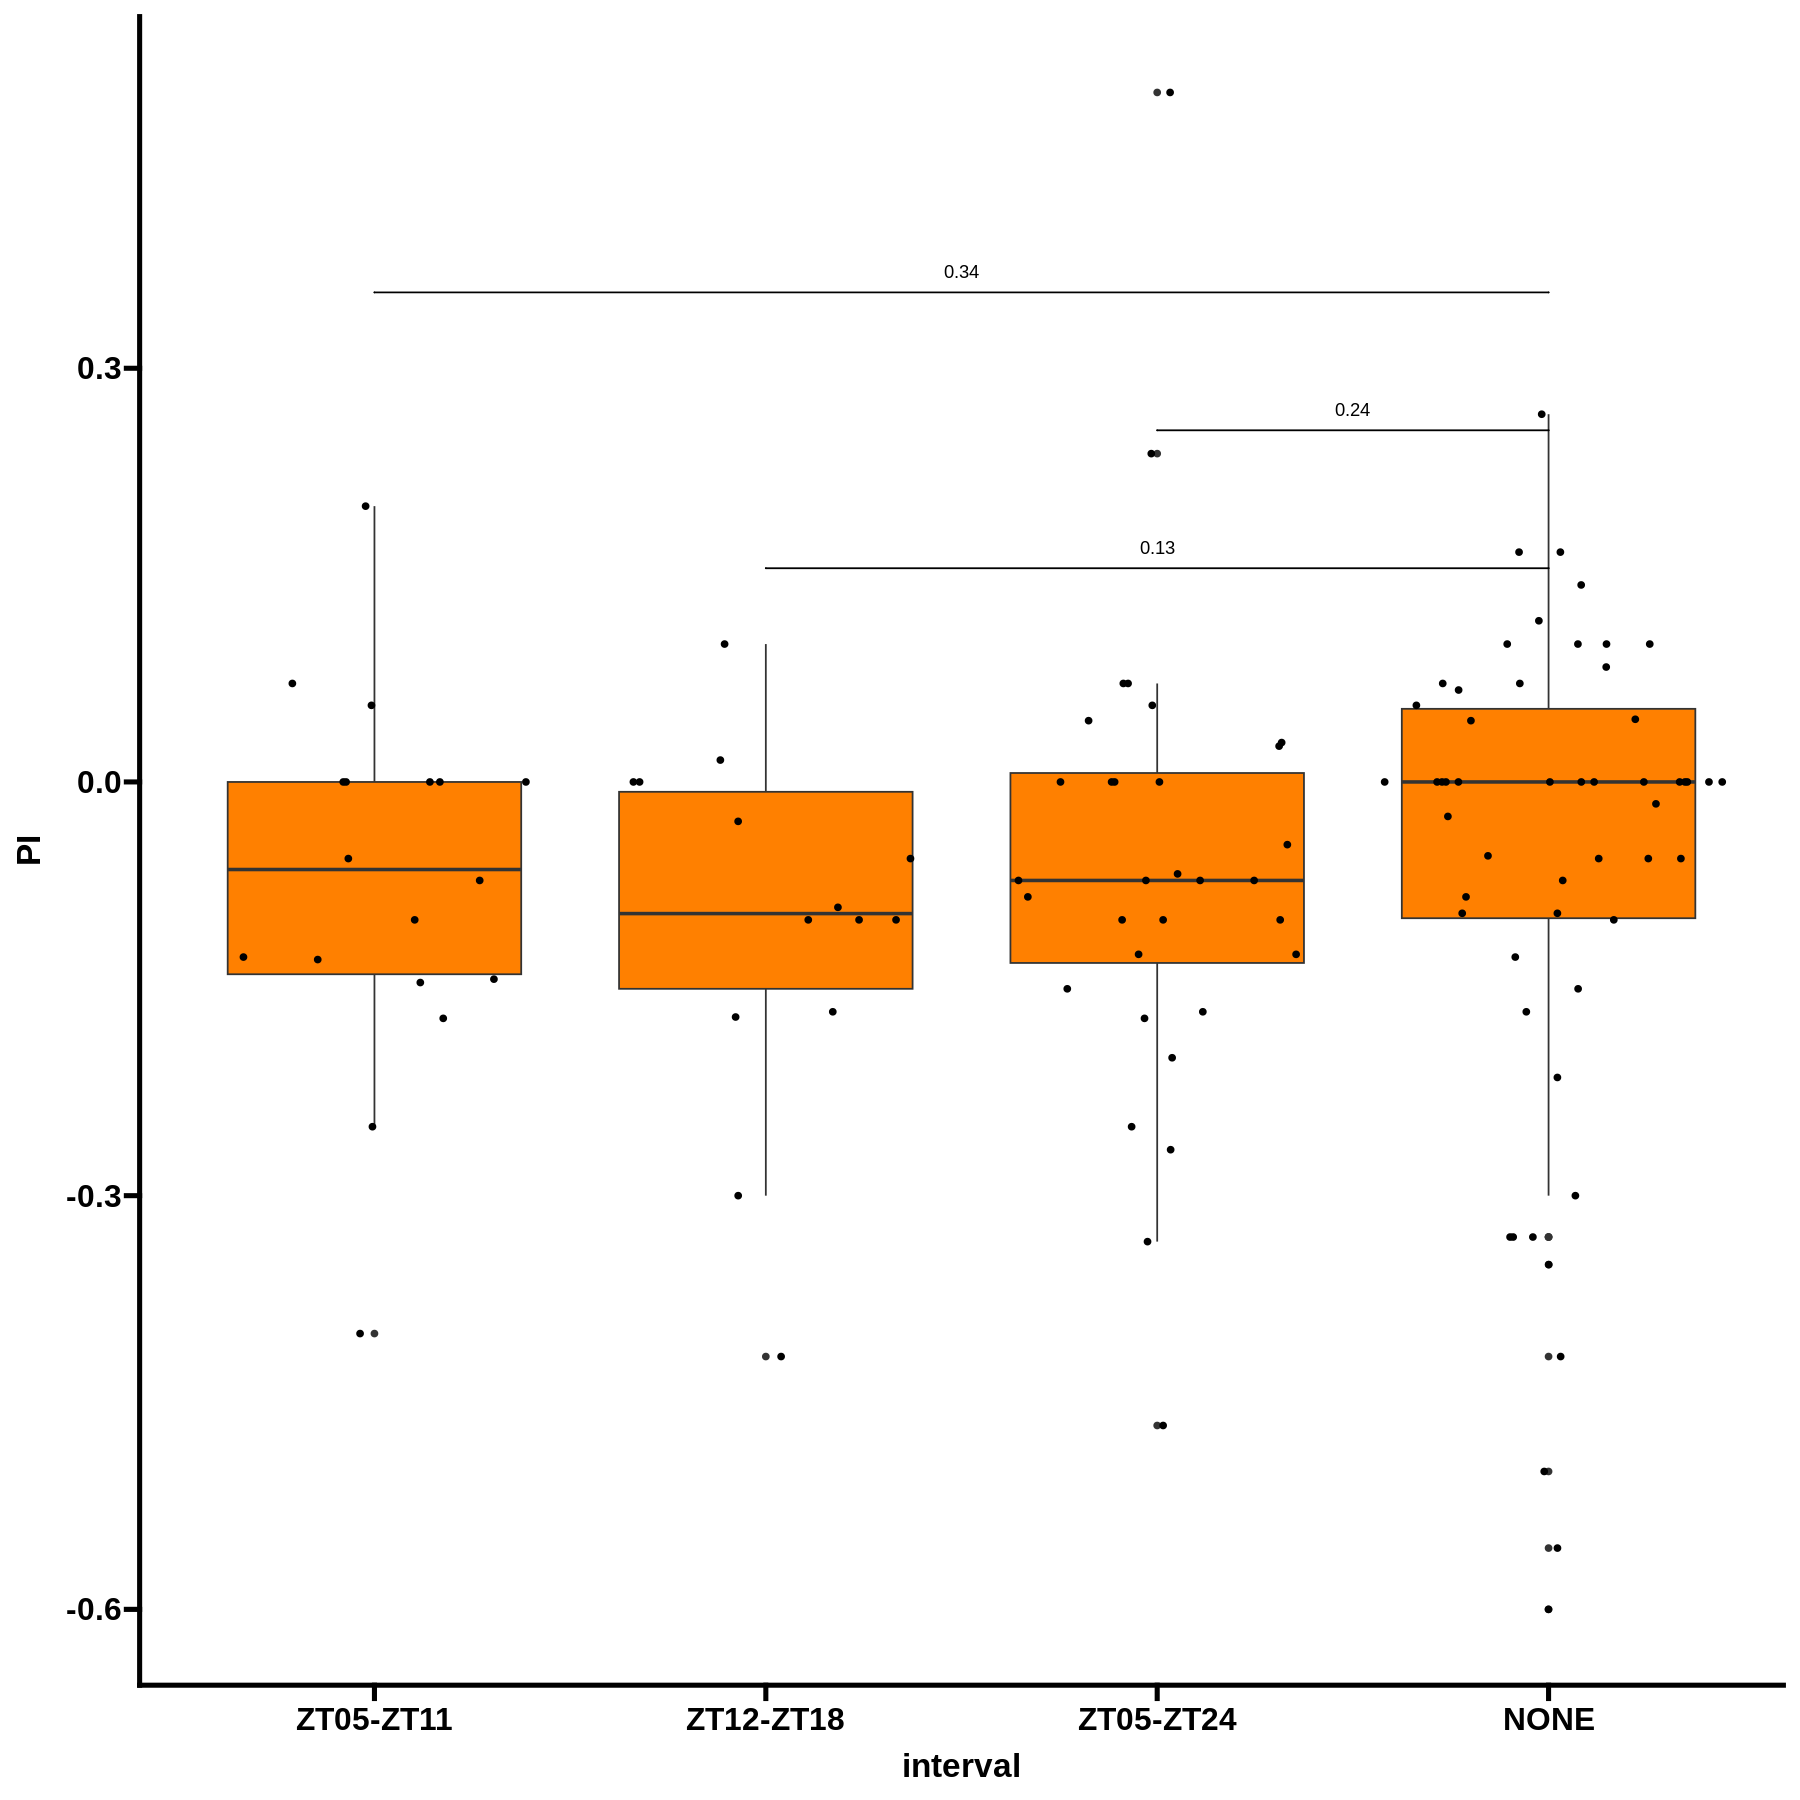

In [119]:
ggplot(data=panel3A_data, aes(x=interval, y=PI)) +
    geom_boxplot(fill="#ff8000") +
    geom_sina() +
    labs(y="PI") +
    geom_signif(
        comparisons = list(
            c("NONE", "ZT05-ZT11")
        ), map_signif_level = FALSE,
        y_position = .3, tip_length = 0, vjust = 0.2
    ) +
    geom_signif(
        comparisons = list(
            c("NONE", "ZT05-ZT24")
        ), map_signif_level = FALSE,
        y_position = .2, tip_length = 0, vjust = 0.2
    ) +
    geom_signif(
        comparisons = list(
            c("NONE", "ZT12-ZT18")
        ), map_signif_level = FALSE,
        y_position = .1, tip_length = 0, vjust = 0.2
    ) 
    # geom_errorbar(width=.2, mapping=aes(ymin=POST-std, ymax=POST+std))

In [503]:
panel3A <- ggplot(
    data=panel3_data[interval=="NONE" & test == "POST",],
    mapping = aes(x=asleep_total, y=PI)
) + geom_point() +
    geom_smooth(method = MASS::rlm) + labs(x="ZT05-ZT11 sleep (mins)") +
    scale_x_continuous(breaks=seq(0, 240, 60)) +
    scale_y_continuous(limits=c(-0.5, 0.3))
ggsave(filename = "figures/panel3A.svg", plot = panel3A, width=7.5, height=5)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


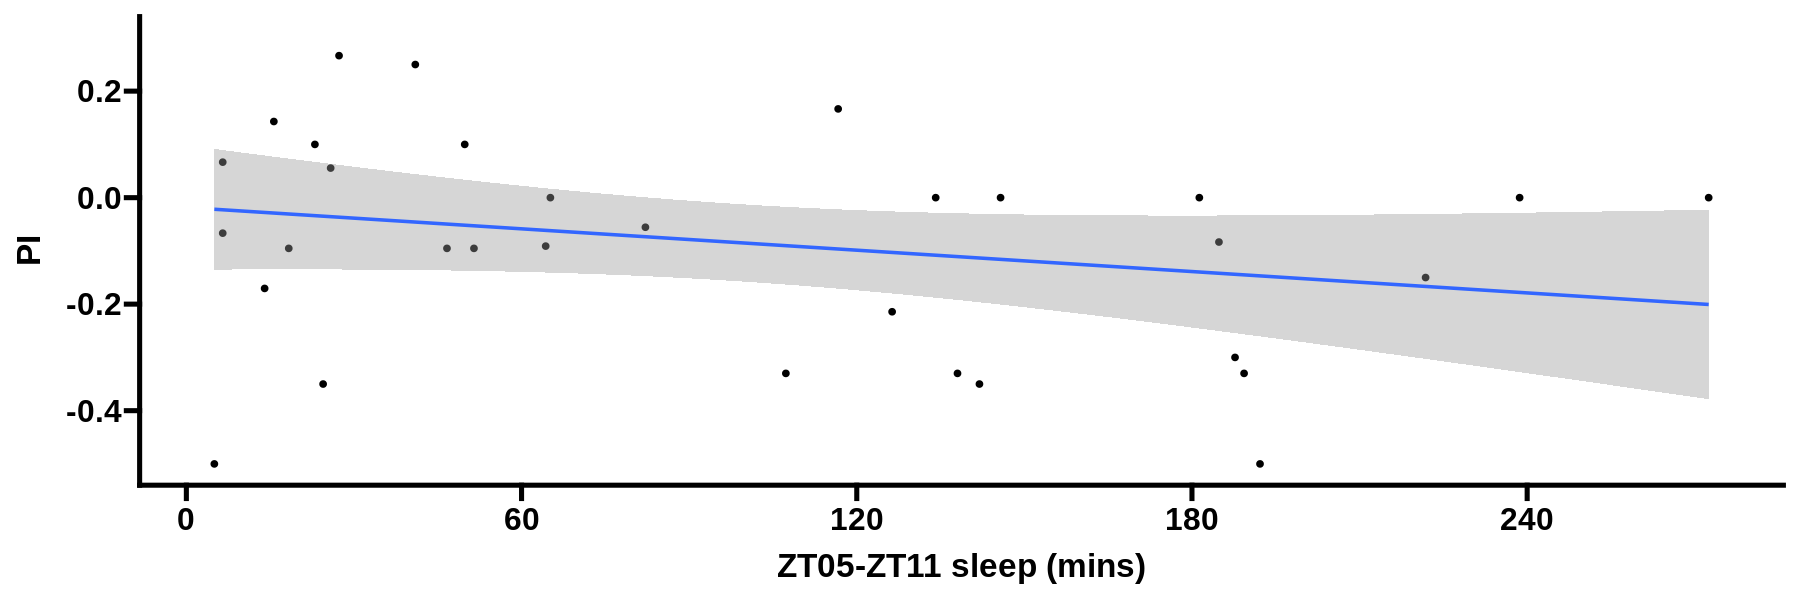

In [504]:
panel3A